In [148]:
import pandas
import numpy
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from matplotlib.pyplot import hist
from ipywidgets import Dropdown, interact, Output, Button
from IPython.display import display as dsp
!gdown "1AtV2siB18mx_SVShM3zWdyDSdBCnge0t&confirm=t"
%matplotlib inline

# Getting initial data and setting important values for future use
# First read the relevant data from github
match_data = pandas.read_csv('https://raw.githubusercontent.com/keelanderrick/capstone/refs/heads/main/data/training_data.csv',header=0)
hero_names = pandas.read_csv('https://raw.githubusercontent.com/keelanderrick/capstone/refs/heads/main/data/hero_names.csv',header=0)
num_heroes = 110  # Number of heroes in Dota 2, easily adjustable in case more are added
X = match_data.iloc[:, 1:num_heroes*2+1]  # The features which will be used to predict - in this case it is the columns representing each hero
Y = match_data.iloc[:, 0]                 # The predicted/result column, representing which team won. 1 if radiant and 0 if dire
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25) # Splitting the data into a training set and a test set

# Model variable and parameter grid - tuned for best results after testing
model = LogisticRegression()
param_grid = {
    'penalty': ['l2'],
    'C': [1],
    'solver': ['lbfgs']
}

# Training the model on our training data
# I use grid search because it gave me the best results after testing
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train.values, Y_train.values)
model.fit(X_train.values, Y_train.values)
Y_pred = grid_search.predict(X_test.values) # Generating a set of predicted results from the training data

In [149]:
# Printing the accuracy rating on the training and test set
print('Accuracy on training set:{:.2f}'.format(grid_search.score(X_train.values, Y_train.values)))
print('Accuracy on test set:{:.2f}'.format(grid_search.score(X_test.values, Y_test.values)))

Accuracy on training set:0.61
Accuracy on test set:0.60


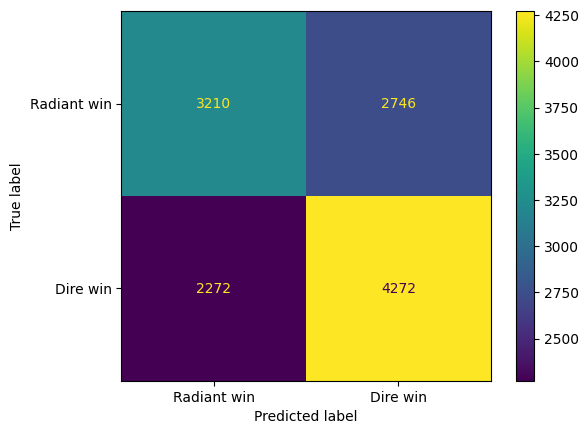

In [150]:
# Displaying a confusion matrix
# Shows how many times the model predicted certain results vs how many times they were actually true
display = ConfusionMatrixDisplay(confusion_matrix(Y_test, Y_pred), display_labels={'Radiant win', 'Dire win'})
display.plot()
plt.show()

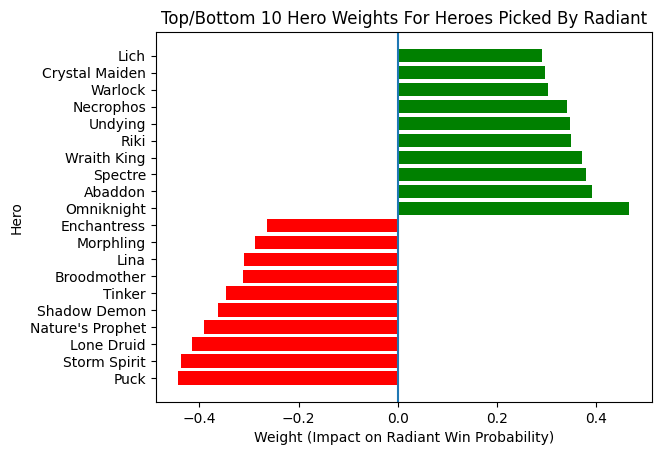

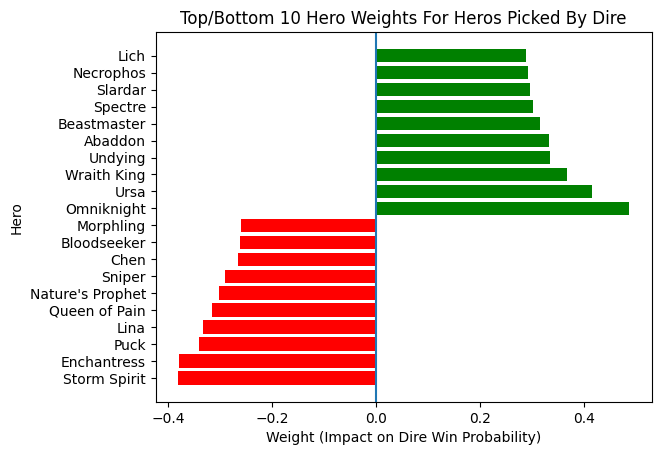

In [151]:
# I'll be displaying two bar graphs showing the top and bottom 10 heroes either team can pick
# in terms of their weights

# Get the coefficient array
coefs = model.coef_[0]
# Create two data frames, one for the hero if picked on radiant and one for if its picked on dire
# Each data frame is a pair consisting of the hero's name and its weight
coef_array_radiant = pandas.DataFrame ({
    "Hero": hero_names['localized_name'],
    "Weight": coefs[:110]
})

coef_array_dire = pandas.DataFrame ({
    "Hero": hero_names['localized_name'],
    "Weight": coefs[110:]
})

# Sort the data frames by weight
# Note that the radiant and dire ones are flipped, because the dire wins if the result is 0
# but the radiant wins if the result is 1, meaning dire needs its weights 'reversed' for it
# to represent their point of view
top10_radiant = coef_array_radiant.sort_values("Weight", ascending=False).head(10)
bottom10_radiant = coef_array_radiant.sort_values("Weight", ascending=True).head(10)
top10_dire = coef_array_dire.sort_values("Weight", ascending=True).head(10)
bottom10_dire = coef_array_dire.sort_values("Weight", ascending=False).head(10)

# Create the radiant bar graph
# Combine the top and bottom 10
radiant_hist = pandas.concat([bottom10_radiant, top10_radiant])
# Colors for styling
colors = ["green" if w > 0 else "red" for w in radiant_hist["Weight"]]
# Create the actual bar graph and axis line
plt.barh(radiant_hist["Hero"], radiant_hist["Weight"], color=colors)
plt.axvline(0)
# Labels
plt.title("Top/Bottom 10 Hero Weights For Heroes Picked By Radiant")
plt.xlabel("Weight (Impact on Radiant Win Probability)")
plt.ylabel("Hero")
plt.show()

# Repeat for the dire, note that the x axis is 'flipped' to shift it to Dire's perspective
dire_hist = pandas.concat([bottom10_dire,top10_dire])
colors = ["green" if w < 0 else "red" for w in dire_hist["Weight"]]
plt.barh(dire_hist["Hero"], dire_hist["Weight"]*-1, color=colors)
plt.axvline(0)
plt.title("Top/Bottom 10 Hero Weights For Heros Picked By Dire")
plt.xlabel("Weight (Impact on Dire Win Probability)")
plt.ylabel("Hero")
plt.show()

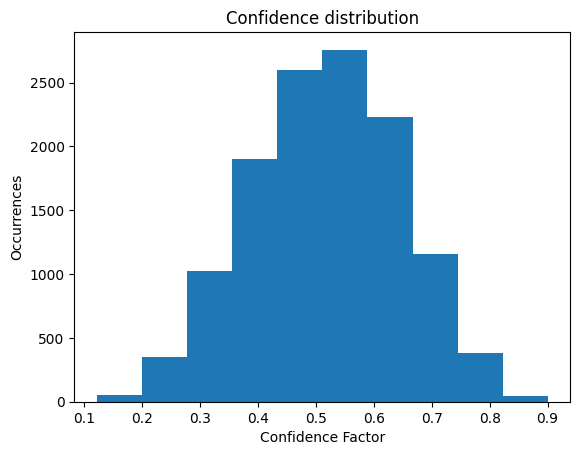

In [152]:
# A histogram showing how often the model had varying levels of confidence in its prediction
probs = grid_search.predict_proba(X_test.values)
hist(probs[:,1])
plt.xlabel('Confidence Factor')
plt.ylabel('Occurrences')
plt.title('Confidence distribution')
plt.show()

In [158]:
# In this segment I will create the user interface for the user to input their predictions
localized_names = hero_names.iloc[:,2]  # Using the hero names .csv file, get an array of just the localized names

# I'm going to create 5 drop downs for each team
# Creating the radiant dropdowns
# Each one will be labeled 1-5 and default to Anti-Mage (the first hero)
radiant_heroes = []
for i in range(5):
  radiant_heroes.append(Dropdown(
      options=localized_names,
      value='Anti-Mage',
      description='Hero ' + str(i+1) + ':',
      disabled=False,
  ))

# Creating the dire dropdowns
dire_heroes = []
for i in range(5):
  dire_heroes.append(Dropdown(
      options=localized_names,
      value='Anti-Mage',
      description='Hero ' + str(i+1) + ':',
      disabled=False,
  ))

# The predict button
button = Button(
    description='Predict',
    disabled=False,
    button_style='',
    tooltip='Get a prediction',
)

# Funcion for getting a prediction
def get_prediction(self):
  # Arrays containing the values of each dropdown
  radiant_values = []
  dire_values = []
  # Populating the arrays based on what each dropdown contains when button is pushed
  for hero in radiant_heroes:
    radiant_values.append(hero.value)
  for hero in dire_heroes:
    dire_values.append(hero.value)
  # List of heroes, this is going to be the row fed to the model for prediction
  # Initialized to contain only 0's
  hero_list = []
  hero_list.append([0] * num_heroes*2)

  # For every radiant hero submitted by the user, set its corresponding column in the row to 1
  # If there is a hero submitted twice, tell the user to submit again because a hero can only be picked once in a game
  for hero in radiant_values:
    if radiant_values.count(hero) > 1 or hero in dire_values:
      print('Ensure that any hero only appears once and try again')
      return
    else:
      hero_list[0][numpy.where(localized_names == hero)[0][0]] = 1  # It looks weird but this is just setting the corresponding cell for a hero to 1

  # Repeat this process for every dire hero
  for hero in dire_values:
    if dire_values.count(hero) > 1 or hero in radiant_values:
      print('Ensure that any hero only appears once and try again')
      return
    else:
      # Added num_heroes to the index because rows 0 thru num_heroes are radiant and rows num_heroes thru num_heroes*2 are dire
      hero_list[0][numpy.where(localized_names == hero)[0][0] + num_heroes] = 1

  # Output the prediction to the user
  if grid_search.predict(hero_list) == [1]:
    probability = grid_search.predict_proba(hero_list)[0][1] * 100
    print(f'Predicted Radiant victory with probability of {probability:.1f}%')
  else:
    probability = grid_search.predict_proba(hero_list)[0][0] * 100
    dsp(f'Predicted Dire victory with probability of {probability:.1f}%')

  return

# Bind the get_prediction function to the button
button.on_click(get_prediction)

# Display the dropdowns and button
output_area = Output()
dsp("Radiant Team:", output_area)
for dropdown in radiant_heroes:
  dsp(dropdown, output_area)

dsp("Dire Team:", output_area)
for dropdown in dire_heroes:
  dsp(dropdown, output_area)

dsp(button, output_area)


'Radiant Team:'

Output()

Dropdown(description='Hero 1:', options=('Anti-Mage', 'Axe', 'Bane', 'Bloodseeker', 'Crystal Maiden', 'Drow Ra…

Output()

Dropdown(description='Hero 2:', options=('Anti-Mage', 'Axe', 'Bane', 'Bloodseeker', 'Crystal Maiden', 'Drow Ra…

Output()

Dropdown(description='Hero 3:', options=('Anti-Mage', 'Axe', 'Bane', 'Bloodseeker', 'Crystal Maiden', 'Drow Ra…

Output()

Dropdown(description='Hero 4:', options=('Anti-Mage', 'Axe', 'Bane', 'Bloodseeker', 'Crystal Maiden', 'Drow Ra…

Output()

Dropdown(description='Hero 5:', options=('Anti-Mage', 'Axe', 'Bane', 'Bloodseeker', 'Crystal Maiden', 'Drow Ra…

Output()

'Dire Team:'

Output()

Dropdown(description='Hero 1:', options=('Anti-Mage', 'Axe', 'Bane', 'Bloodseeker', 'Crystal Maiden', 'Drow Ra…

Output()

Dropdown(description='Hero 2:', options=('Anti-Mage', 'Axe', 'Bane', 'Bloodseeker', 'Crystal Maiden', 'Drow Ra…

Output()

Dropdown(description='Hero 3:', options=('Anti-Mage', 'Axe', 'Bane', 'Bloodseeker', 'Crystal Maiden', 'Drow Ra…

Output()

Dropdown(description='Hero 4:', options=('Anti-Mage', 'Axe', 'Bane', 'Bloodseeker', 'Crystal Maiden', 'Drow Ra…

Output()

Dropdown(description='Hero 5:', options=('Anti-Mage', 'Axe', 'Bane', 'Bloodseeker', 'Crystal Maiden', 'Drow Ra…

Output()

Button(description='Predict', style=ButtonStyle(), tooltip='Get a prediction')

Output()

Predicted Radiant victory with probability of 70.2%
